## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus

import os
import time
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import Transformer, WarmUpThenDecay
from src.data_handling import read_first_n, sample_batch


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080, compute capability 8.9


In [3]:
def batch(corpus, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(corpus)
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=100*batch_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True)

    steps_per_epoch = len(corpus) // batch_size
    
    return ds, steps_per_epoch

In [7]:
max_seq_len = 768

tokenizer = pkl.load(open("tokenizers/tokenizer_coqa_8k.pkl", "rb"))
tokenizer.create_hash()
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>", "<pad>"])

In [8]:
print(tokenizer.token_to_idx["<sep>"])
print(tokenizer.token_to_idx["<s>"])
print(tokenizer.token_to_idx["</s>"])
print(tokenizer.token_to_idx["<q>"])
print(tokenizer.token_to_idx["<a>"])
print(tokenizer.token_to_idx["<pad>"])

73
8074
8075
8076
8077
8078


In [9]:
corpus = pkl.load(open('corpus/corpus_coqa_padded_8k', "rb"))

In [10]:
tf.random.set_seed(42)
#shuffle the corpus
corpus = tf.random.shuffle(corpus)

length = corpus.shape[0]

ratio = int(0.95*length)

ds_train, steps_per_epoch = batch(corpus[:ratio], 16)
ds_test, _ = batch(corpus[ratio:], 4)

print(steps_per_epoch)

427


## Define Model

In [24]:
initial_lr = 1e-4
decay_steps = 20000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

embed_dim = 512
tf_blocks = 8
heads = 8
ff_dim = 4*embed_dim
weight_decay = 0.01
dropout = 0.1

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    tokenizer=tokenizer,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    accum_steps=0,
                    )

losses_train = []
losses_test = []


In [25]:
name = "model_CoQA_8k"


ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [11]:
#ckpt.restore(ckpt_manager.latest_checkpoint)
#losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

#model.accum_steps = tf.constant(10, dtype=tf.int32)

In [21]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 29740431


In [22]:
def train_loop(iter_train, iter_test, steps_per_epoch, epochs):
    for i in tqdm(range(steps_per_epoch*epochs)):
        batch_train = next(iter_train)
        batch_test = next(iter_test)
        
        loss_train = model.train_step(batch_train).numpy()
        losses_train.append(loss_train)
        
        loss_test = model.evaluate(batch_test).numpy()
        losses_test.append(loss_test)

        if (i+1) % 1000 == 0:
            ckpt_manager.save()
            pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

        lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
        print(loss_train, loss_test, lr)
    return losses_train, losses_test

In [26]:
iter_train = iter(ds_train)
iter_test = iter(ds_test)

In [54]:
train_loop(iter_train, iter_test, steps_per_epoch, 10)

  0%|          | 0/4270 [00:00<?, ?it/s]

3.4389286 3.9873116 6.640897e-05
3.2116024 4.588872 6.640667e-05
3.0758302 4.3465014 6.640436e-05
3.4595284 4.26993 6.640206e-05
3.2690322 4.2403774 6.6399756e-05
3.315103 4.455321 6.639746e-05
3.5361743 3.7225437 6.6395165e-05
3.540192 4.772231 6.639286e-05
3.4700282 4.217662 6.639055e-05
3.1203854 4.4473124 6.638825e-05
3.3917196 4.676031 6.638595e-05
3.320675 4.093056 6.6383654e-05
3.213521 4.0600433 6.638135e-05
3.4264367 4.1917024 6.637905e-05
3.4108999 4.104222 6.637675e-05
3.2680135 4.0498743 6.637445e-05
3.3971128 4.0187593 6.637215e-05
3.4165578 4.093999 6.6369845e-05
3.3194718 3.9989865 6.6367546e-05
3.334031 3.8255508 6.636525e-05
3.480673 4.606173 6.636295e-05
3.441136 3.883903 6.636065e-05
3.2419333 4.1905403 6.635835e-05
3.2412589 4.384481 6.635605e-05
3.281839 3.8935885 6.635375e-05
3.4480603 4.158558 6.635145e-05
3.4725385 3.842955 6.634915e-05
3.5815358 4.208876 6.634686e-05
3.5488796 3.1337779 6.634455e-05
3.6196837 4.044989 6.6342254e-05
3.4567778 4.5272007 6.6339955

([11.474028,
  11.587386,
  11.562791,
  11.477334,
  11.39574,
  11.473328,
  11.547888,
  11.471274,
  11.43461,
  11.407678,
  11.275513,
  11.250551,
  11.28642,
  11.2220125,
  11.1299715,
  11.120328,
  11.099815,
  11.080107,
  11.025315,
  10.892237,
  10.861735,
  10.7266865,
  10.770482,
  10.625526,
  10.513111,
  10.434739,
  10.402934,
  10.341191,
  10.201874,
  10.167407,
  10.253395,
  10.1116495,
  9.871059,
  10.040263,
  9.8915205,
  9.791953,
  9.69668,
  9.678355,
  9.508694,
  9.496764,
  9.457935,
  9.4584465,
  9.404153,
  9.337106,
  9.267407,
  9.21564,
  9.183374,
  9.117141,
  9.109267,
  8.96996,
  9.038935,
  8.929127,
  8.924241,
  8.881445,
  8.873383,
  8.769021,
  8.711874,
  8.768122,
  8.785206,
  8.726389,
  8.726136,
  8.676711,
  8.624159,
  8.650523,
  8.562056,
  8.528074,
  8.568888,
  8.433066,
  8.476636,
  8.379611,
  8.460344,
  8.395137,
  8.295202,
  8.410667,
  8.300749,
  8.306583,
  8.194585,
  8.185953,
  8.213366,
  8.222098,
  8.170

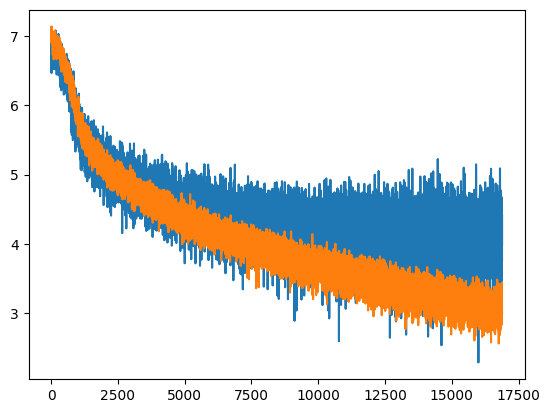

In [55]:
plt.plot(losses_test[200:], label="Test Loss")
plt.plot(losses_train[200:], label="Train Loss")

In [58]:
text = "<s>You are slarn.<q>who are you?<a>"
text = text.lower()
tokens = tf.cast(tokenizer.encode(text), tf.int32)
print(tokens)

tf.Tensor([[8074 1269  215  795 7408   15 8076 4130  215  268   32 8077]], shape=(1, 12), dtype=int32)


In [61]:
import textwrap
import ipywidgets as widgets
from IPython.display import display

#tf.random.set_seed(43)
wrapper = textwrap.TextWrapper(width=80)

# create a read-only text area
ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)


T = 0.5
k = 50

for i in range(1024):
    logits = model.call(tokens)[0, -1:]
    topk_vals, _      = tf.math.top_k(logits, k=k)
    kth_value         = topk_vals[:,-1]

    logits = tf.where(logits >= kth_value, logits, tf.constant(-np.inf, logits.dtype))

    idx = tf.cast(
        tf.random.categorical(logits / T, num_samples=1),
        tf.int32
    ) 
    tokens = tf.concat([tokens, idx], axis=1)

    text_pred = (
        tokenizer
        .decode(tokens)
        .numpy()[0]
        .decode('utf-8')
        .replace("\n", " ")
    )
    ta.value = wrapper.fill(text_pred)  # this updates in-place

    if idx[0, 0] == tokenizer.token_to_idx["</s>"]:
        break

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

KeyboardInterrupt: 

## 

In [ ]:
from sklearn.cluster import KMeans

def cosine_similarity(embed_a, embed_b):
    """
    Compute the cosine similarity between two vectors.
    """
    embed_b_T = tf.transpose(embed_b)
    dot_product = embed_a@embed_b_T
    
    norm_a = tf.linalg.norm(embed_a, axis=1, keepdims=True)
    norm_b = tf.linalg.norm(embed_b_T, axis=0, keepdims=True)

    return dot_product / (norm_a * norm_b)


def cluster(X, n_clusters, normalize=True):
    if normalize:
        X = X/np.linalg.norm(X, axis=1, keepdims=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_

    return inertia, labels, clusters


class EmbeddingClustering:
    def __init__(self, tokenizer, n_clusters=10):
        
        self.tokenizer = tokenizer
        self.n_clusters = n_clusters

    def fit(self, word_embed, normalize=True):
        inertia, labels, clusters = cluster(word_embed, self.n_clusters, normalize)
        self.word_embed = word_embed
        self.inertia = inertia
        self.labels = labels
        self.clusters = tf.convert_to_tensor(clusters, dtype=tf.float32)

        cos_sim = cosine_similarity(self.clusters, word_embed, normalize)
        self.idx_list =  tf.argsort(cos_sim, axis=-1, direction='DESCENDING', stable=False, name=None)

    def print_clusters(self, n_words=10):
        for idx in self.idx_list:
            for i in idx[:n_words]:
                word = self.tokenizer.decode(tf.expand_dims(tf.cast(i, tf.int32), axis=0))
                word = word.numpy().decode('utf-8')
                print(word)
            print("\n")


def cosine_similarity(embed_a, embed_b, normalize=True):
    """
    Compute the cosine similarity between two vectors.
    """
    if normalize:
        embed_a = tf.nn.l2_normalize(embed_a, axis=1)
        embed_b = tf.nn.l2_normalize(embed_b, axis=1)
    dot_product = embed_a@tf.transpose(embed_b)


    return dot_product

In [ ]:
word_embed = model.word_embed
embedding_clustering = EmbeddingClustering(tokenizer, n_clusters=100)
embedding_clustering.fit(word_embed, normalize=True)
embedding_clustering.print_clusters(n_words=10)

steven
robert
john
jason
kevin
stephen
lionel
brian
david
sergio


sadness
belief
excitement
attitude
frustration
sympathy
reminder
skepticism
outrage
impression


croatia
sweden
denmark
belgium
portugal
hungary
romania
switzerland
austria
kazakhstan


treats
covers
moves
hits
fights
handles
feeds
addresses
encourages
aims


eclip
plumme
accum
incre
collap
stif
destab
redu
glimp
unve


bought
produced
enjoyed
invented
attended
received
embraced
commissioned
earned
recruited


urging
asking
expressing
helping
describing
inviting
letting
prompting
allowing
highlighting


illum
acknowled
scrut
discrim
fasc
detr
refle
inst
stair
reper


cities
colleges
sectors
departments
regions
companies
organizations
agencies
institutions
universities


taking
turning
getting
pulling
putting
stepping
moving
returning
trying
sending


ob
con
sub
recon
dis
trans
cir
rein
dist
circum


territor
secutive
portra
attem
mingham
occas
consid
enthus
fahren
theast


certainly
hardly
never
rarely
actually
probably

In [ ]:
word_embed = model.word_embed

text = "he"
text = text.lower()

idx = tf.cast(tokenizer.encode(text), tf.int32)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.decode(i).numpy().decode('utf-8'))

  0%|          | 0/16000 [00:00<?, ?it/s]

tf.Tensor([[103]], shape=(1, 1), dtype=int32)
he
she
he's
they
his
i
he'd
it
"
we
an
who
him
a
she's
himself
there
that
'i
they've
you
he'll
'
i've
which
it's
president
but
being
man
i'm
her
obama
ever
the
we've
gu
what
be
no
nobody
vic
they're
she'd
this
then
ger
father
someone
never
'we
chief
one
nelson
leader
people
son
whose
lau
smith
and
men
you're
che
so
was
we're
sch
as
you've
prosecutors
bush
ke
''
while
not
er
too
jur
boy
 
authorities
ch
once
they'd
director
even
bin
anyone
still
professor
doctors
i'd
me
members
wa


officials
whoever
ali


In [ ]:
word_embed = model.word_embed

text = "the terrorists killed the civilians"
text = text.lower()

indices = tf.cast(tokenizer.encode(text), tf.int32)
embeds = model.call(indices, logits=False)
embed_mean1 = tf.cast(tf.reduce_mean(embeds, axis=1), dtype=tf.float32)

text = "the criminals were violent towards the people"
text = text.lower()
indices = tf.cast(tokenizer.encode(text), tf.int32)
embeds = model.call(indices, logits=False)
embed_mean2 = tf.cast(tf.reduce_mean(embeds, axis=1), dtype=tf.float32)

text = "The cat was cute"
text = text.lower()
indices = tf.cast(tokenizer.encode(text), tf.int32)
embeds = model.call(indices, logits=False)
embed_mean3 = tf.cast(tf.reduce_mean(embeds, axis=1), dtype=tf.float32)

text = "Dogs are so adorable"
text = text.lower()
indices = tf.cast(tokenizer.encode(text), tf.int32)
embeds = model.call(indices, logits=False)
embed_mean4 = tf.cast(tf.reduce_mean(embeds, axis=1), dtype=tf.float32)


cosine_sim1 = cosine_similarity(embed_mean1, embed_mean2, normalize=True)

cosine_sim2 = cosine_similarity(embed_mean3, embed_mean4, normalize=True)
cosine_sim3 = cosine_similarity(embed_mean1, embed_mean3, normalize=True)
cosine_sim4 = cosine_similarity(embed_mean2, embed_mean4, normalize=True)
print(cosine_sim1)
print(cosine_sim2)
print(cosine_sim3)
print(cosine_sim4)


  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

tf.Tensor([[0.83709925]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6219947]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.67831075]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6626094]], shape=(1, 1), dtype=float32)
